In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
MagE = pd.read_csv('RF_MagE_Freq2.csv')
MagE_freq = np.array(MagE['Frequency (GHz)'])
MagE_3mils = np.array(MagE[' Maximum MagE 3mils (V/m)'])
MagE_6mils = np.array(MagE[' Maximum MagE 6mils (V/m)'])

del MagE

In [3]:
res = pd.read_csv('Resonance2.csv')
res_sliced = res[res['resonator_l [in]'] == 2.4]
res_3mils = res_sliced[res_sliced['resonator_w [in]'] == 0.054]
res_6mils = res_sliced[res_sliced['resonator_w [in]'] == 0.060]

freq = np.array(res_3mils['Freq [GHz]'])
S21_3mils = np.array(res_3mils['dB(St(wguide_T2,wguide_T1)) []'])
S21_6mils = np.array(res_6mils['dB(St(wguide_T2,wguide_T1)) []'])

del res, res_sliced, res_3mils, res_6mils

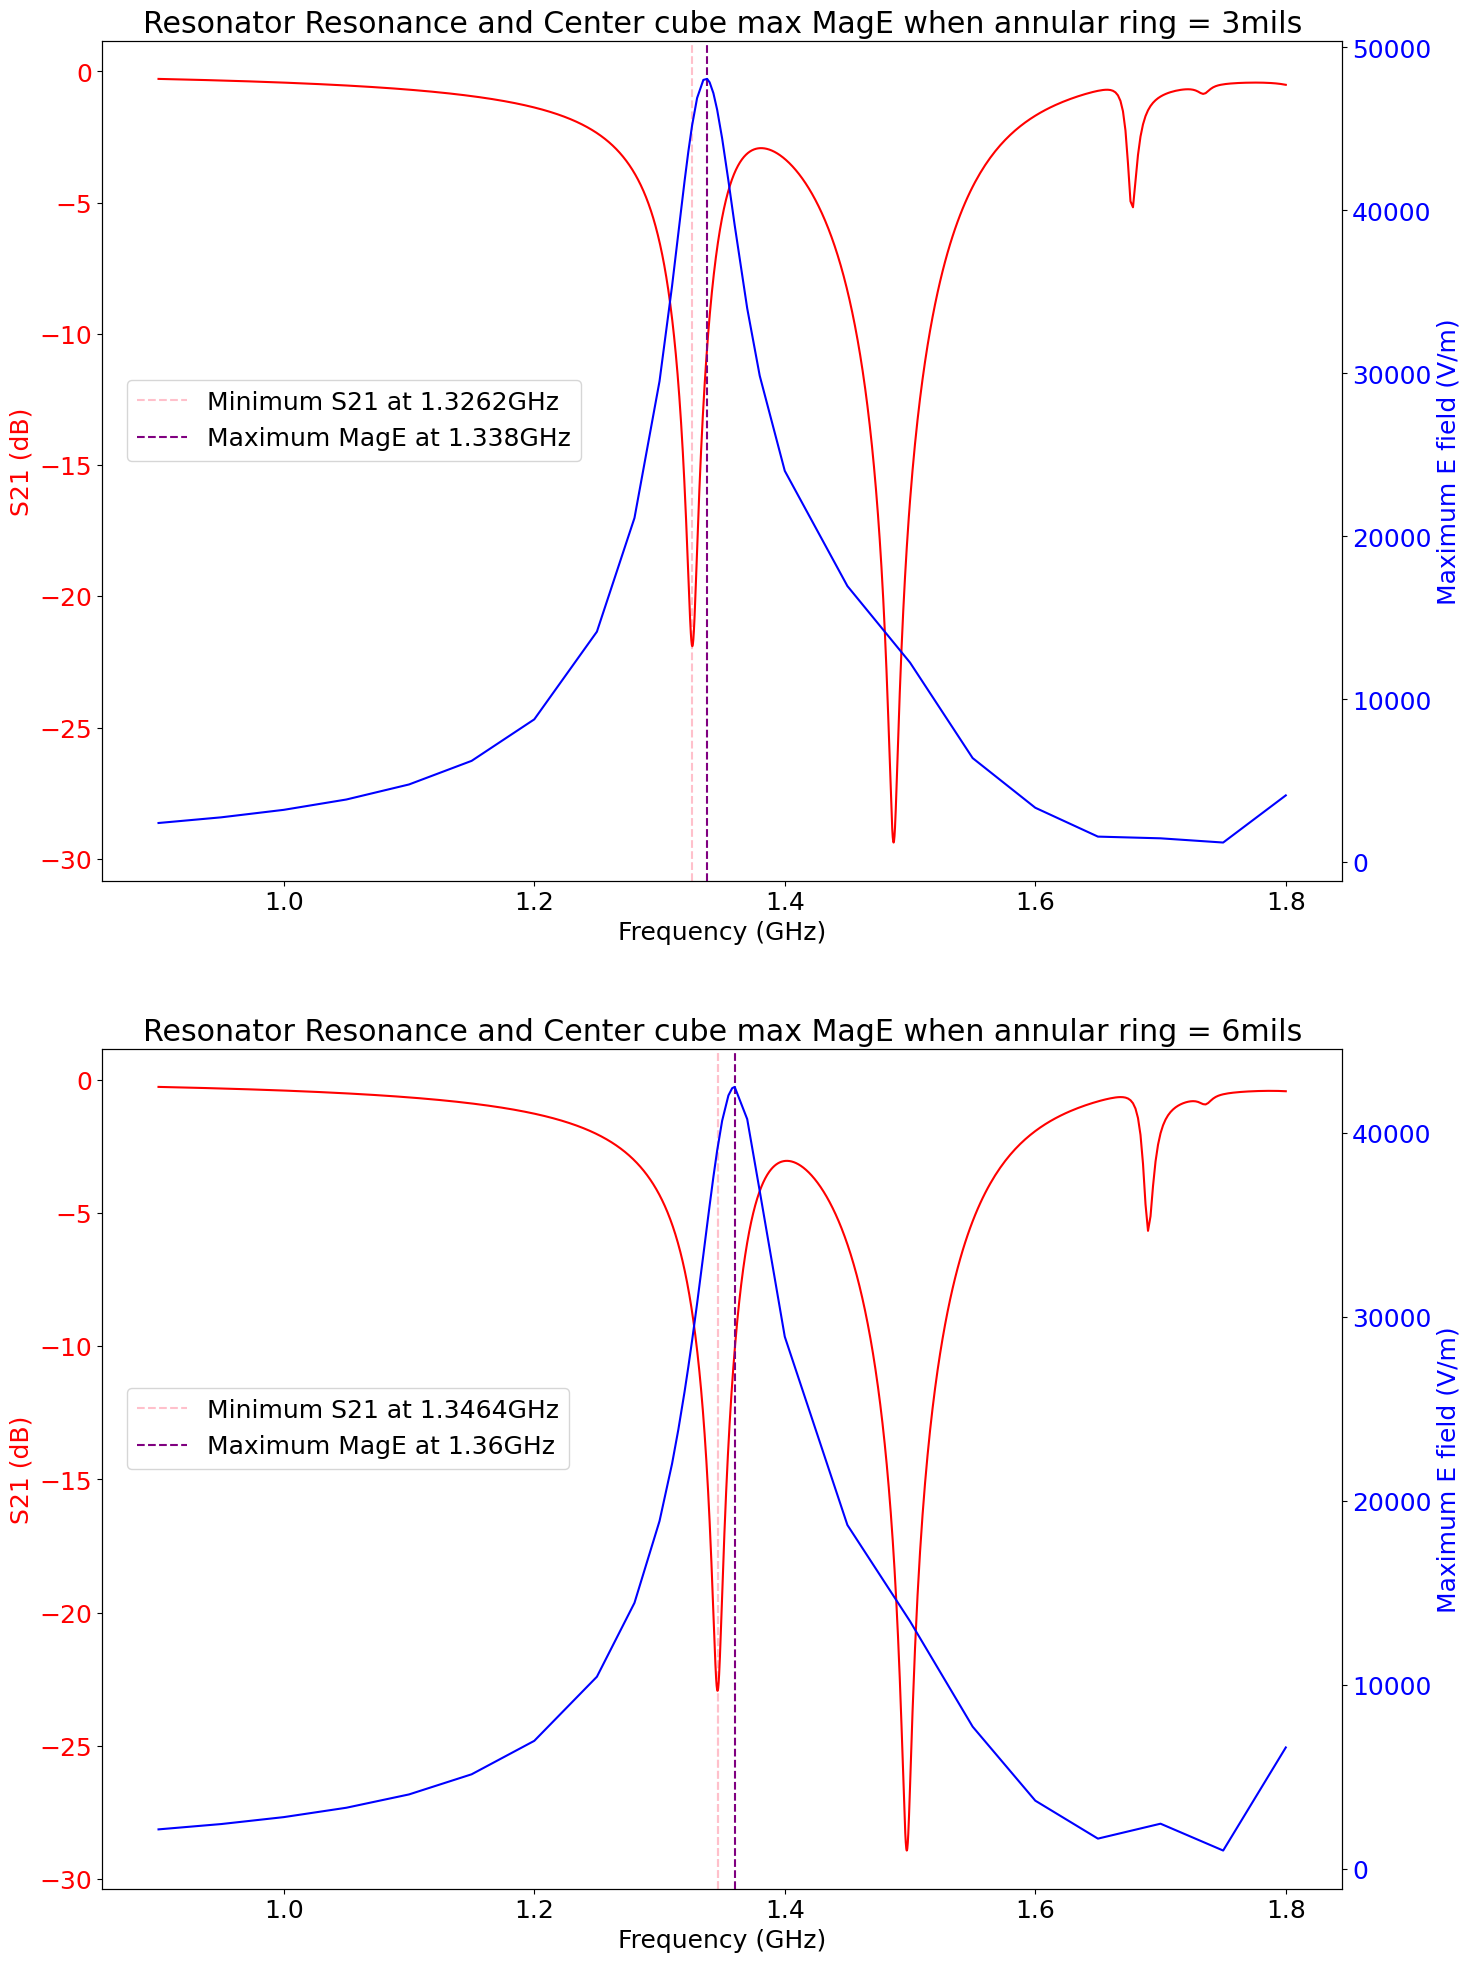

In [4]:
plt.rcParams['figure.figsize'] = (16, 24)
plt.rcParams['font.size'] = 18

fig, (ax1, ax2) = plt.subplots(2, 1)
ln1 = ax1.axvline(x=freq[S21_3mils[freq<1.4].argmin()], linestyle='--', color='pink', label=f'Minimum S21 at {freq[S21_3mils[freq<1.4].argmin()]}GHz')
ax1.plot(freq[freq<=1.8], S21_3mils[freq<=1.8], 'r-')
ax1.set_ylabel('S21 (dB)', color='r')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_title('Resonator Resonance and Center cube max MagE when annular ring = 3mils')
ax1.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ln2 = ax3.axvline(x=MagE_freq[MagE_3mils.argmax()], linestyle='--', color='purple', label=f'Maximum MagE at {MagE_freq[MagE_3mils.argmax()]}GHz')
ax3.plot(MagE_freq, MagE_3mils, 'b-')
ax3.set_ylabel('Maximum E field (V/m)', color='b')
ax3.tick_params(axis='y', labelcolor='b')

lns1 = [ln1, ln2]
labs1 = [l.get_label() for l in lns1]
ax1.legend(lns1, labs1, loc=(0.02, 0.5))

ax2.axvline(x=freq[S21_6mils[freq<1.4].argmin()], linestyle='--', color='pink')
ln3 = ax2.axvline(x=freq[S21_6mils[freq<1.4].argmin()], linestyle='--', color='pink', label=f'Minimum S21 at {freq[S21_6mils[freq<1.4].argmin()]}GHz')
ax2.plot(freq[freq<=1.8], S21_6mils[freq<=1.8], 'r-')
ax2.set_ylabel('S21 (dB)', color='r')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_title('Resonator Resonance and Center cube max MagE when annular ring = 6mils')
ax2.tick_params(axis='y', labelcolor='r')

ax4 = ax2.twinx()
ln4 = ax4.axvline(x=MagE_freq[MagE_6mils.argmax()], linestyle='--', color='purple', label=f'Maximum MagE at {MagE_freq[MagE_6mils.argmax()]}GHz')
ax4.plot(MagE_freq, MagE_6mils, 'b-')
ax4.set_ylabel('Maximum E field (V/m)', color='b')
ax4.tick_params(axis='y', labelcolor='b')

lns2 = [ln3, ln4]
labs2 = [l.get_label() for l in lns2]
ax2.legend(lns2, labs2, loc=(0.02, 0.5))

In [21]:
def calculate_pseudopotential(fields, freq, m, q):
    
    Ups = (q * fields) ** 2 / (4 * m * (2 * np.pi * freq) ** 2)
    Ups = Ups / abs(q)
    
    return Ups

In [27]:
def pseudopotential_from_3D(filename, freq, m=9.1093837e-31, q=-1.60217663e-19):
    
    filedata = pd.read_csv(filename, delimiter=' ', skiprows=1)

    x = np.unique(filedata['X,'])
    y = np.unique(filedata['Y,'])
    z = np.unique(filedata['Z,'])
    xs, ys, zs = np.meshgrid(x, y, z, indexing='ij')

    try:
        f = filedata['data']
    except:
        f = filedata['Scalar data Mag_E']
    fields = f.values.reshape(len(x), len(y), len(z))

    Ups = calculate_pseudopotential(fields, freq, m, q)

    return xs, ys, zs, Ups

In [49]:
def pseudopotential_from_2D(filename, freq, plane, m=9.1093837e-31, q=-1.60217663e-19):

    filedata = pd.read_csv(filename, delimiter=' ', skiprows=1)
    filedata.replace('Nan', np.nan, inplace=True)

    try:
        filedata['data'] = pd.to_numeric(filedata['data'], errors='coerce')
    except KeyError:
        filedata['Scalar data Mag_E'] = pd.to_numeric(filedata['Scalar data Mag_E'], errors='coerce')
    
    if plane == 'xy':
        axis1, axis2 = 'X,', 'Y,'
    elif plane == 'xz':
        axis1, axis2 = 'X,', 'Z,'
    elif plane == 'yz':
        axis1, axis2 = 'Y,', 'Z,'
    else:
        raise ValueError('plane must be xy, xz, or yz')

    coord1 = np.unique(filedata[axis1])
    coord2 = np.unique(filedata[axis2])
    grid2, grid1 = np.meshgrid(coord2, coord1)

    fields = filedata['data'].values.reshape(len(coord1), len(coord2))

    # 计算伪势
    Ups = calculate_pseudopotential(fields, freq, m, q)

    return grid1, grid2, Ups, coord1, coord2

In [97]:
from matplotlib.colors import LogNorm

def plot_pseudopotential_plane_2D(prefix, freq, m=9.1093837e-31, q=-1.60217663e-19, suptitle_note='', vmin=1e-2, vmax=1e+2, cmap='bwr'):
    '''You can use this function to make your code easier, if your
    Name your exported field file in correct format'''

    try:
        xs_xy, ys_xy, Ups_xy, x, y = pseudopotential_from_2D(prefix + '_xy.fld', freq, 'xy')
        xs_xz, zs_xz, Ups_xz, _, z = pseudopotential_from_2D(prefix + '_xz.fld', freq, 'xz')
        ys_yz, zs_yz, Ups_yz, _, _ = pseudopotential_from_2D(prefix + '_yz.fld', freq, 'yz')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

    fig, axes = plt.subplots(3, 1, figsize=(8.5, 21))
    fig.suptitle('RF Pseudopotential ' + suptitle_note)

    # Note that Ansys axis (x, y, z) is trap axis (y, z, x)
    c1 = axes[0].pcolormesh(xs_xy*1e3, ys_xy*1e3, Ups_xy, norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    cb1 = fig.colorbar(c1, ax=axes[0])
    cb1.set_label('RF Pseudopotential (eV)')
    axes[0].set_title('YZ Plane')
    axes[0].set_xlabel('Y (mm)')
    axes[0].set_ylabel('Z (mm)')

    c2 = axes[1].pcolormesh(ys_yz*1e3, zs_yz*1e3, Ups_yz, norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    cb2 = fig.colorbar(c2, ax=axes[1])
    cb2.set_label('RF Pseudopotential (eV)')
    axes[1].set_title('ZX Plane')
    axes[1].set_xlabel('Z (mm)')
    axes[1].set_ylabel('X (mm)')

    c3 = axes[2].pcolormesh(xs_xz*1e3, zs_xz*1e3, Ups_xz, norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    cb3 = fig.colorbar(c3, ax=axes[2])
    cb3.set_label('RF Pseudopotential (eV)')
    axes[2].set_title('YX Plane')
    axes[2].set_xlabel('Y (mm)')
    axes[2].set_ylabel('X (mm)')

    fig.tight_layout()
    plt.show()

    # Pre process for axis plotting
    Ups_x = Ups_xy[:, np.abs(y).argmin()]
    Ups_y = Ups_xy[np.abs(x).argmin(), :]
    Ups_z = Ups_xz[np.abs(x).argmin(), :]

    return ((z, x, y), (Ups_z, Ups_x, Ups_y))

In [137]:
import matplotlib.gridspec as gridspec

def plot_pseudopotential_axis_2D(data, suptitle_note='', filter_range = 4e-04):

    coords = data[0]
    Ups_axes = data[1]
    
    gs = gridspec.GridSpec(2, 3, height_ratios=[4,1])
    fig = plt.figure(figsize=(15,6))
    fig.suptitle('RF Pseudopotential ' + suptitle_note)
    
    coeffs = []
    polys = []
    omega = []
    fit = []
    axes = [None] * 6
    
    for i in range(len(coords)):
        valid_mask = np.abs(coords[i]) < filter_range
        filtered_coords = coords[i][valid_mask]
        filtered_Ups_axes = Ups_axes[i][valid_mask]
        
        coeffs.append(np.polyfit(filtered_coords, filtered_Ups_axes, 2))
        polys.append(np.poly1d(coeffs[-1]))
        fit.append(polys[-1](filtered_coords))
        omega.append(np.sqrt(-2 * q * coeffs[-1][0] / m) / (2*np.pi*1e6))
        axes[2*i] = fig.add_subplot(gs[0,i])
        axes[2*i].plot(filtered_coords*1e+03, filtered_Ups_axes, label='Data')
        axes[2*i].plot(filtered_coords*1e+03, fit[-1], '--', label=r'Fit $\omega = 2\pi\times${:.1f}MHz'.format(omega[-1]))
        axes[2*i].legend()
        axes[2*i+1] = fig.add_subplot(gs[1,i])
        axes[2*i+1].plot(filtered_coords*1e+03, (filtered_Ups_axes-fit[-1])*1e+03)
        axes[2*i+1].set_xticks([])

    axes[0].set_ylabel('RF Pseudopotential (eV)')
    axes[1].set_ylabel(r'$\Delta$ (meV)')
    axes[0].set_title('X Axis')
    axes[0].set_xlabel('X (mm)')
    axes[2].set_title('Y Axis')
    axes[2].set_xlabel('Y (mm)')
    axes[4].set_title('Z Axis')
    axes[4].set_xlabel('Z (mm)')

    fig.tight_layout()
    plt.show()

In [30]:
def pseudopotentials_3D(filename, freq):

    # Under Construnction
    
    xs, ys, zs, Ups = pseudopotential_from_3D(filename, freq)

    index_x = np.abs(xs[:,0,0]).argmin()
    index_y = np.abs(ys[0,:,0]).argmin()
    index_z = np.abs(zs[0,0,:]).argmin()

C:\Users\lluoz\AppData\Local\Temp\ipykernel_4872\2657191928.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  filedata = pd.read_csv(filename, delimiter=' ', skiprows=1)
C:\Users\lluoz\AppData\Local\Temp\ipykernel_4872\2657191928.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  filedata = pd.read_csv(filename, delimiter=' ', skiprows=1)


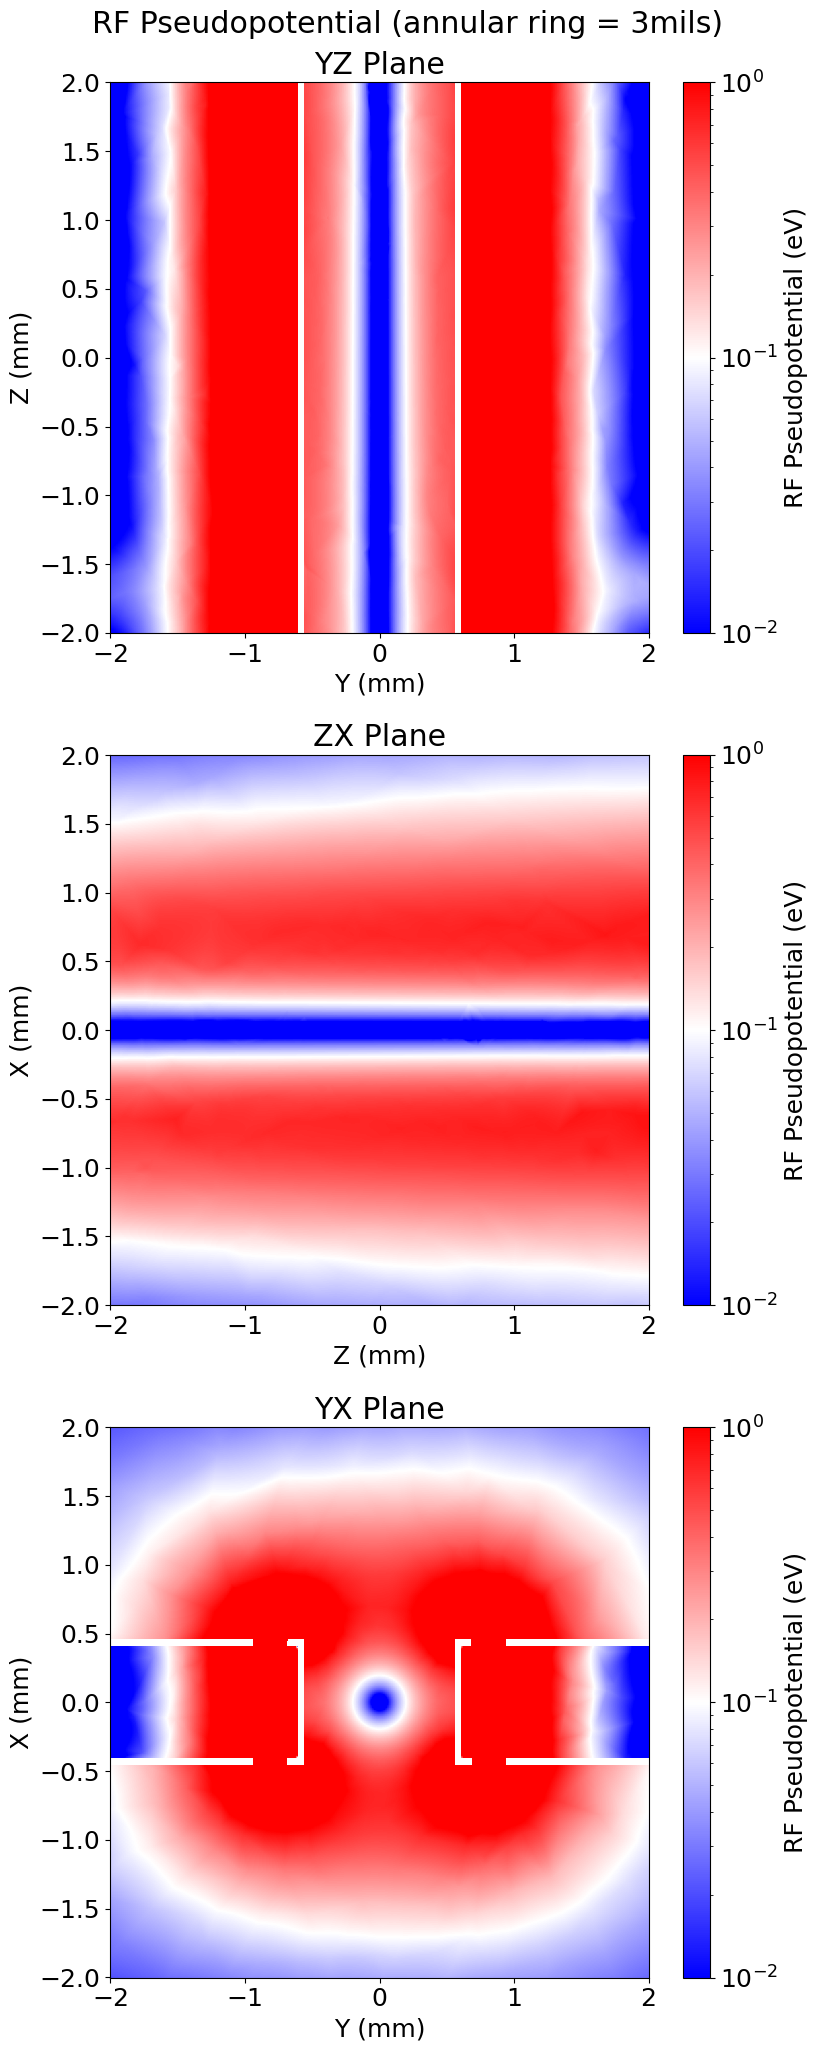

In [98]:
freq_3mils = MagE_freq[MagE_3mils.argmax()] * 1e+9
data_3mils = plot_pseudopotential_plane_2D('RF_Fields_3mils_feed10V', freq_3mils, vmax=1e+0, suptitle_note='(annular ring = 3mils)')

C:\Users\lluoz\AppData\Local\Temp\ipykernel_4872\2657191928.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  filedata = pd.read_csv(filename, delimiter=' ', skiprows=1)
C:\Users\lluoz\AppData\Local\Temp\ipykernel_4872\2657191928.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  filedata = pd.read_csv(filename, delimiter=' ', skiprows=1)


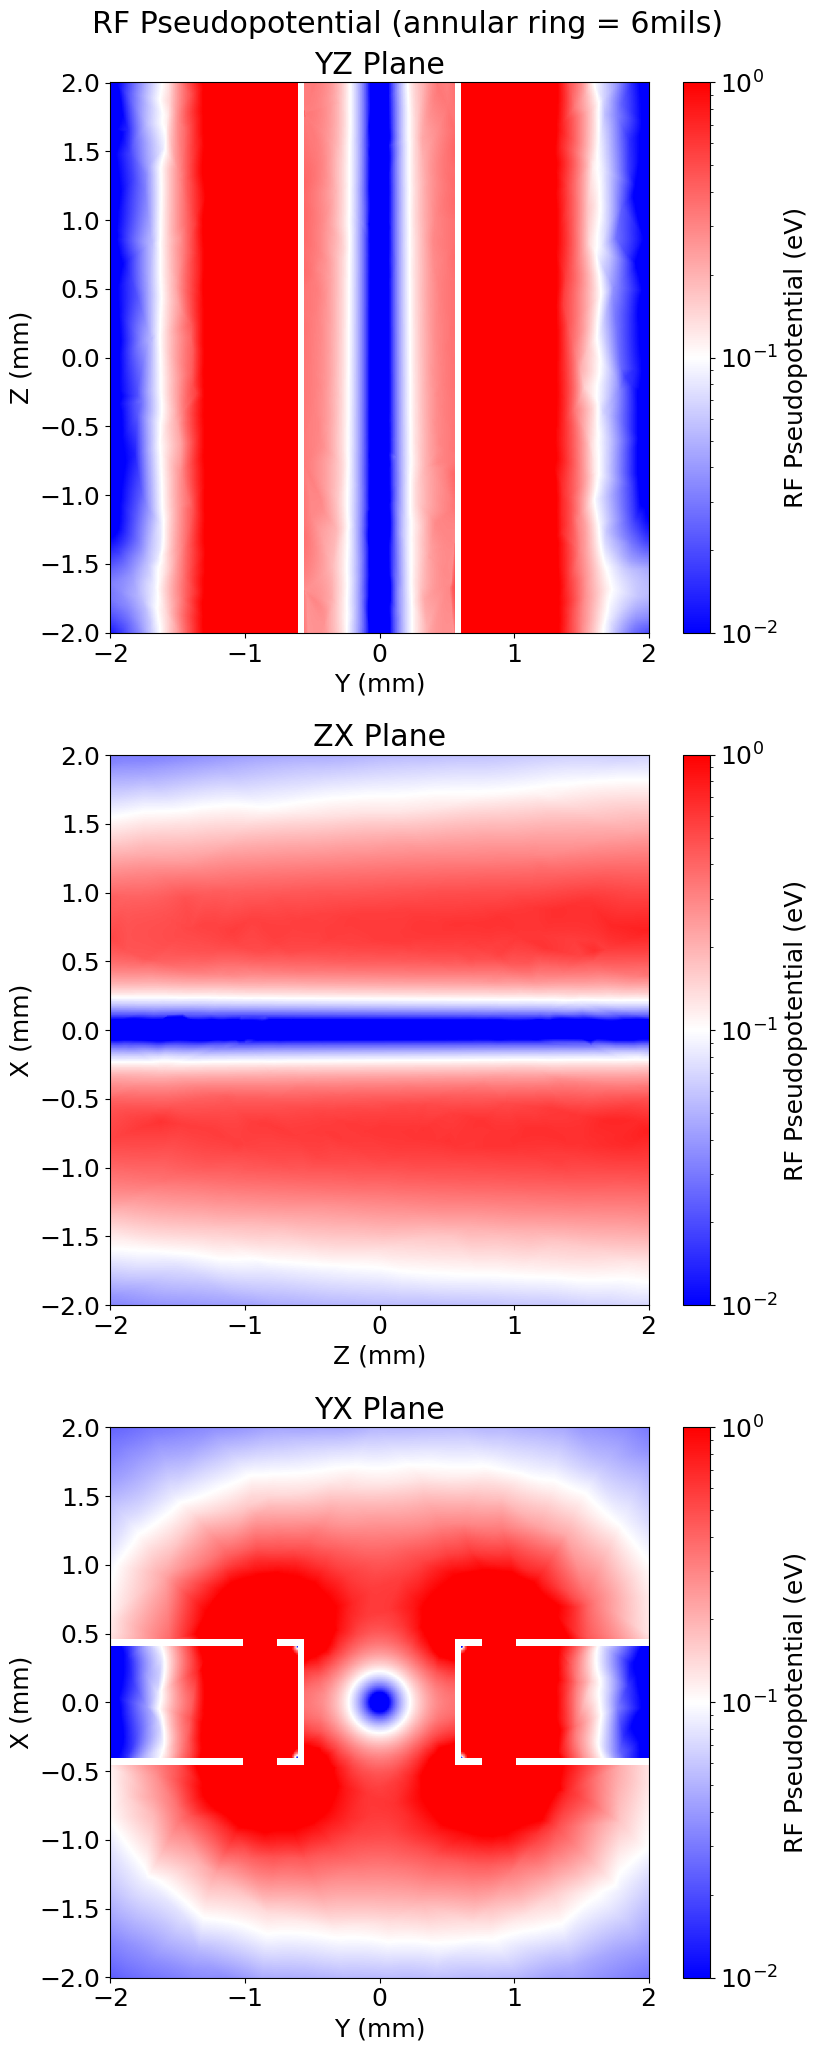

In [99]:
freq_6mils = MagE_freq[MagE_6mils.argmax()] * 1e+9
data_6mils = plot_pseudopotential_plane_2D('RF_Fields_6mils_feed10V', freq_6mils, vmax=1e+0, suptitle_note='(annular ring = 6mils)')

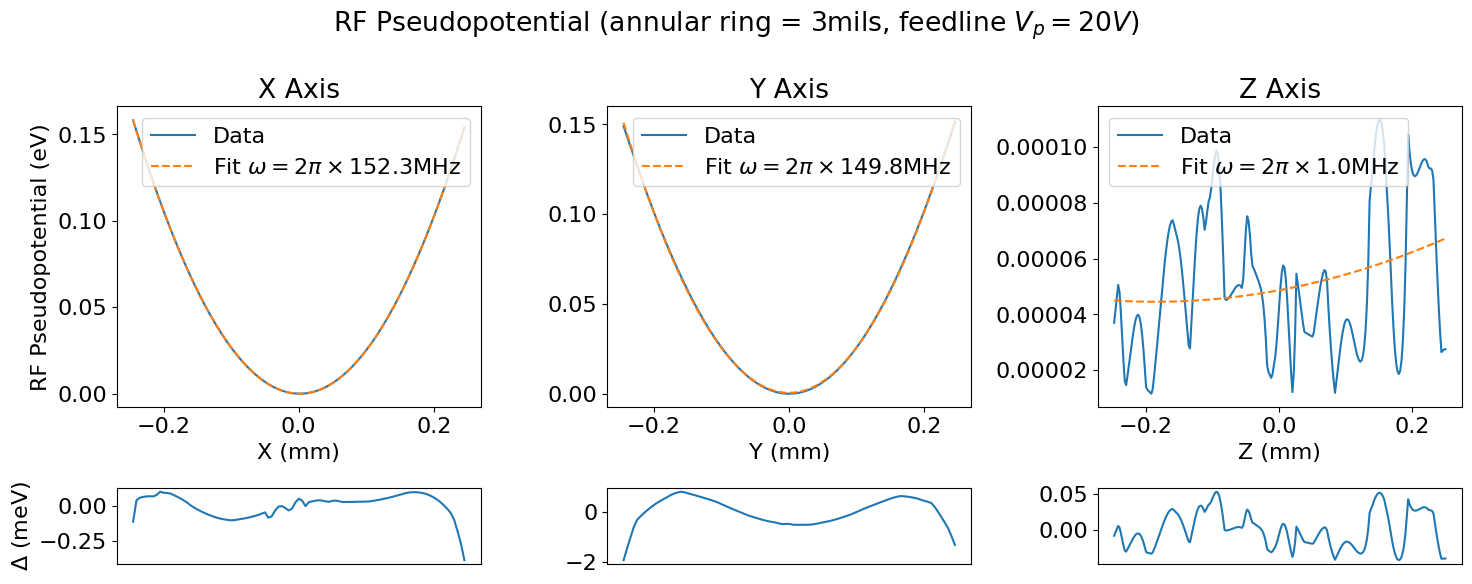

In [143]:
plt.rcParams['font.size'] = 16
plot_pseudopotential_axis_2D(data_3mils, r'(annular ring = 3mils, feedline $V_p=20V$)', filter_range=2.5e-04)

C:\Users\lluoz\AppData\Local\Temp\ipykernel_4872\3612535685.py:26: RuntimeWarning: invalid value encountered in sqrt
  omega.append(np.sqrt(-2 * q * coeffs[-1][0] / m) / (2*np.pi*1e6))


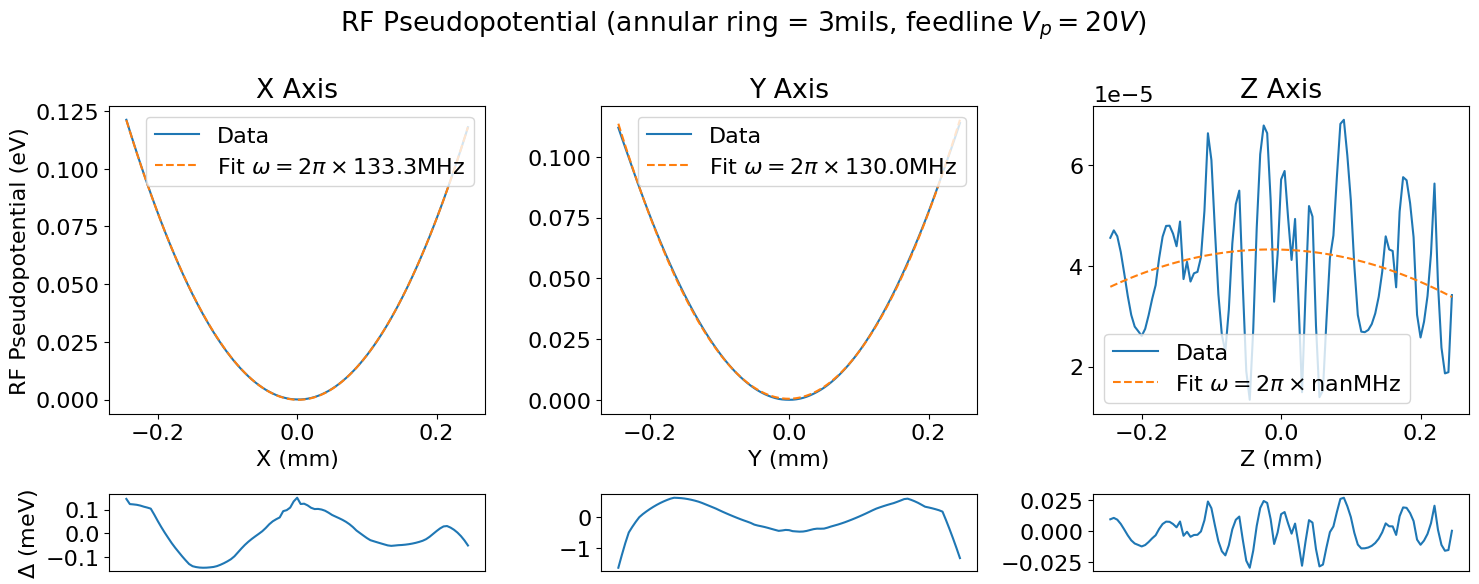

In [144]:
plot_pseudopotential_axis_2D(data_6mils, r'(annular ring = 3mils, feedline $V_p=20V$)', filter_range=2.5e-04)

C:\Users\lluoz\AppData\Local\Temp\ipykernel_4872\3892678452.py:16: RuntimeWarning: invalid value encountered in sqrt
  omega_y2 = np.sqrt(-2 * q * coef_y2[0] / m) / 1e6


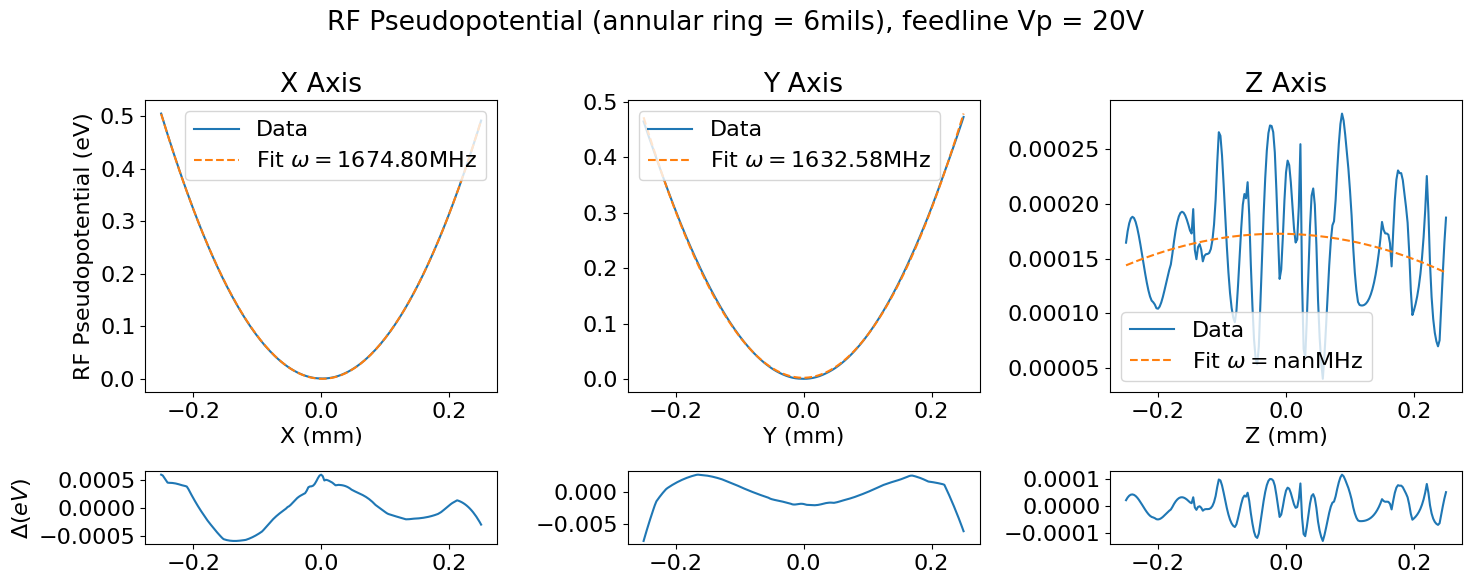

In [142]:
mid_index = len(zs2) // 2

Ups_x2 = Ups2[:, mid_index, mid_index]
Ups_y2 = Ups2[mid_index, :, mid_index]
Ups_z2 = Ups2[mid_index, mid_index, :]

coef_z2 = np.polyfit(zs2[mid_index, mid_index, :], Ups_z2, 2)
poly_z2 = np.poly1d(coef_z2)
coef_x2 = np.polyfit(xs2[:, mid_index, mid_index], Ups_x2, 2)
poly_x2 = np.poly1d(coef_x2)
coef_y2 = np.polyfit(ys2[mid_index, :, mid_index], Ups_y2, 2)
poly_y2 = np.poly1d(coef_y2)

omega_z2 = np.sqrt(-2 * q * coef_z2[0] / m) / 1e6
omega_x2 = np.sqrt(-2 * q * coef_x2[0] / m) / 1e6
omega_y2 = np.sqrt(-2 * q * coef_y2[0] / m) / 1e6

fit_z2 = poly_z2(zs2[mid_index, mid_index, :])
fit_x2 = poly_x2(xs2[:, mid_index, mid_index])
fit_y2 = poly_y2(ys2[mid_index, :, mid_index])

gs2 = gridspec.GridSpec(2, 3, height_ratios=[4, 1])
fig2 = plt.figure(figsize=(15, 6))
fig2.suptitle('RF Pseudopotential (annular ring = 6mils), feedline Vp = 20V')

axes21 = fig2.add_subplot(gs2[0, 0])
axes21.plot(zs2[mid_index, mid_index, :]*1e3, Ups_z2, label='Data')
axes21.plot(zs2[mid_index, mid_index, :]*1e3, fit_z2, '--', label=r'Fit $\omega = $' + '{:.2f}'.format(omega_z2) + 'MHz')
axes21.set_title('X Axis')
axes21.set_xlabel('X (mm)')
axes21.set_ylabel('RF Pseudopotential (eV)')
axes21.legend()

axes22 = fig2.add_subplot(gs2[0, 1])
axes22.plot(xs2[:, mid_index, mid_index]*1e3, Ups_x2, label='Data')
axes22.plot(xs2[:, mid_index, mid_index]*1e3, fit_x2, '--', label=r'Fit $\omega = $' + '{:.2f}'.format(omega_x2) + 'MHz')
axes22.set_title('Y Axis')
axes22.set_xlabel('Y (mm)')
axes22.legend()

axes23 = fig2.add_subplot(gs2[0, 2])
axes23.plot(ys2[mid_index, :, mid_index]*1e3, Ups_y2, label='Data')
axes23.plot(ys2[mid_index, :, mid_index]*1e3, fit_y2, '--', label=r'Fit $\omega = $' + '{:.2f}'.format(omega_y2) + 'MHz')
axes23.set_title('Z Axis')
axes23.set_xlabel('Z (mm)')
axes23.legend()

axes24 = fig2.add_subplot(gs2[1, 0])
axes24.plot(zs2[mid_index, mid_index, :]*1e3, Ups_z2-fit_z2)
axes24.set_ylabel(r'$\Delta (eV)$')

axes25 = fig2.add_subplot(gs2[1, 1])
axes25.plot(xs2[:, mid_index, mid_index]*1e3, Ups_x2-fit_x2)

axes26 = fig2.add_subplot(gs2[1, 2])
axes26.plot(ys2[mid_index, :, mid_index]*1e3, Ups_y2-fit_y2)

plt.tight_layout()

In [12]:
# The result looks weird, use UCB's design to debug
# Reason is the \Omega in the formula is angular frequency, not frequency, so a factor of 2*np.pi should be multiplied
UCB_2D = pd.read_csv('2D_Reference_90V.fld', delimiter = ' ', skiprows=1)
x3 = np.unique(UCB_2D['X,'])
y3 = np.unique(UCB_2D['Y,'])
ys3, xs3 = np.meshgrid(y3, x3)
f3 = UCB_2D['data']
fields3 = f3.values.reshape(len(x3), len(y3))

del UCB_2D, x3, y3, f3

In [13]:
# Convert to Pseudopotential
Ups3 = (q * fields3) ** 2 / (4 * m * (2 * np.pi * 1.6e+09)**2) / (-q)

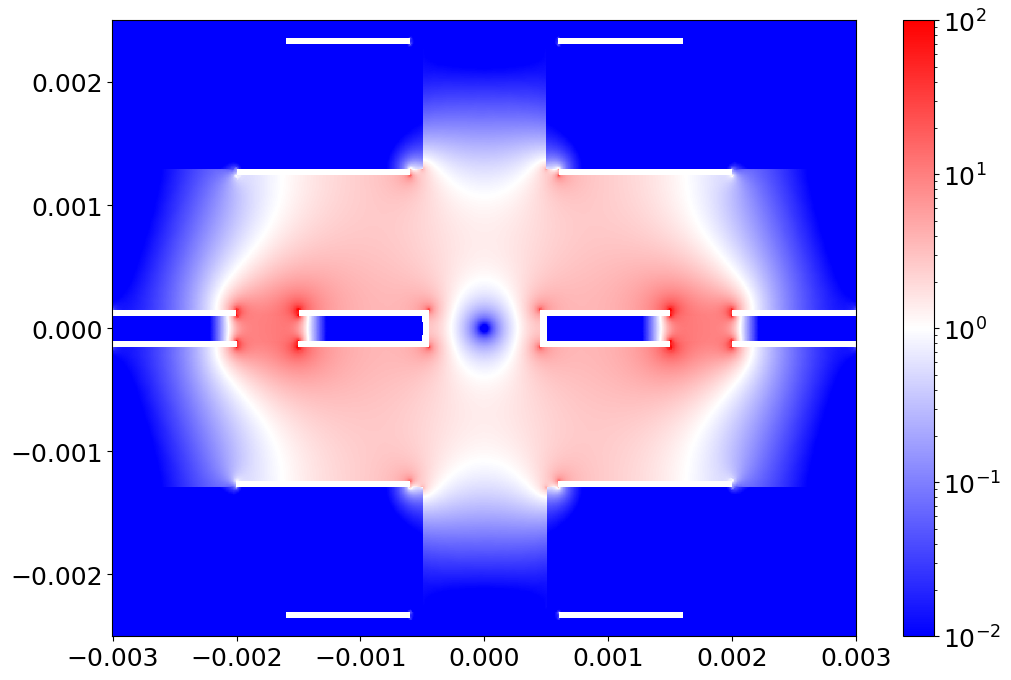

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
c = ax.pcolormesh(xs3, ys3, Ups3, norm=LogNorm(vmin=1e-2, vmax=1e+2), cmap='bwr')
cb = fig.colorbar(c)

(0.0, 3.0)

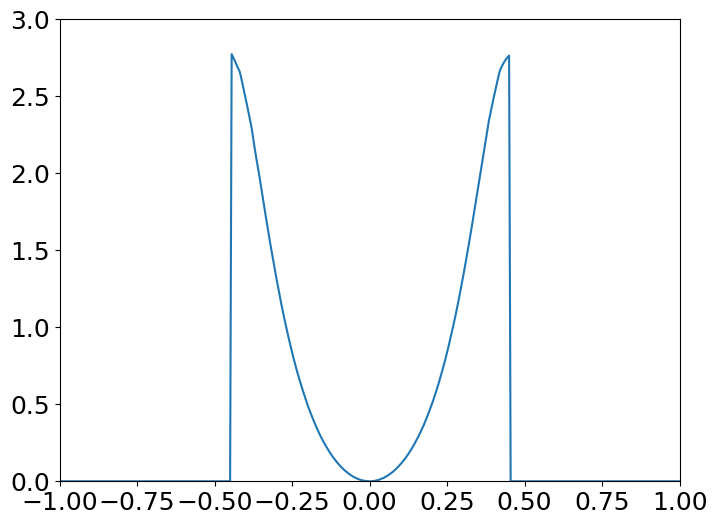

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(xs3[ys3==0]*1e3, Ups3[ys3==0])
plt.xlim((-1, 1))
plt.ylim((0, 3))

In [16]:
# The result looks weird, use UCB's design to debug
UCR_2D = pd.read_csv('2D_Actual_90V.fld', delimiter = ' ', skiprows=1)
x4 = np.unique(UCR_2D['X,'])
y4 = np.unique(UCR_2D['Y,'])
ys4, xs4 = np.meshgrid(y4, x4)
f4 = UCR_2D['data']
fields4 = f4.values.reshape(len(x4), len(y4))

del UCR_2D, x4, y4, f4

In [17]:
Ups4 = (q * fields4) ** 2 / (4 * m * (2 * np.pi * 1.36e+09)**2) / (-q)

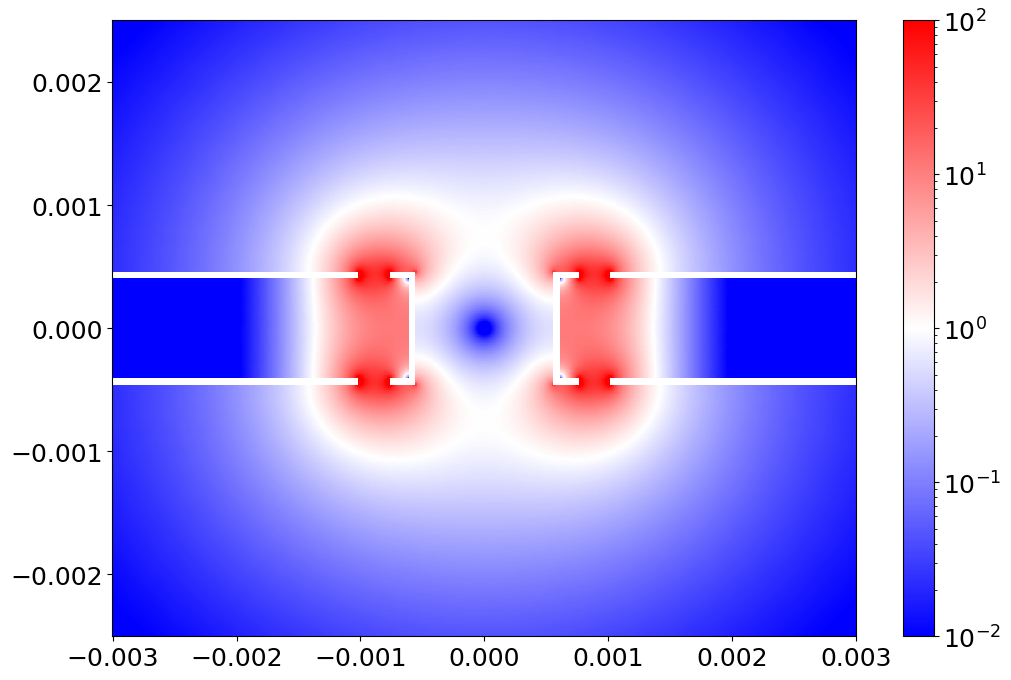

In [18]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
c = ax.pcolormesh(xs4, ys4, Ups4, norm=LogNorm(vmin=1e-2, vmax=1e+2), cmap='bwr')
cb = fig.colorbar(c)

(0.0, 0.6)

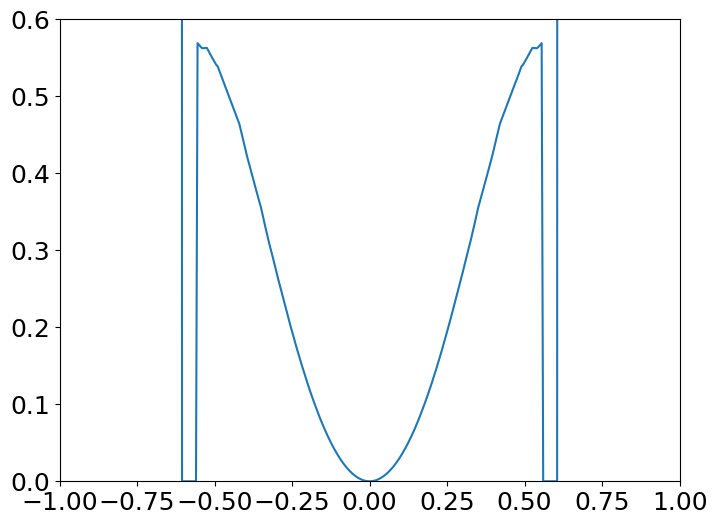

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(xs4[ys4==0]*1e3, Ups4[ys3==0])
plt.xlim((-1, 1))
plt.ylim((0, 0.6))

(0.0, 1.1)

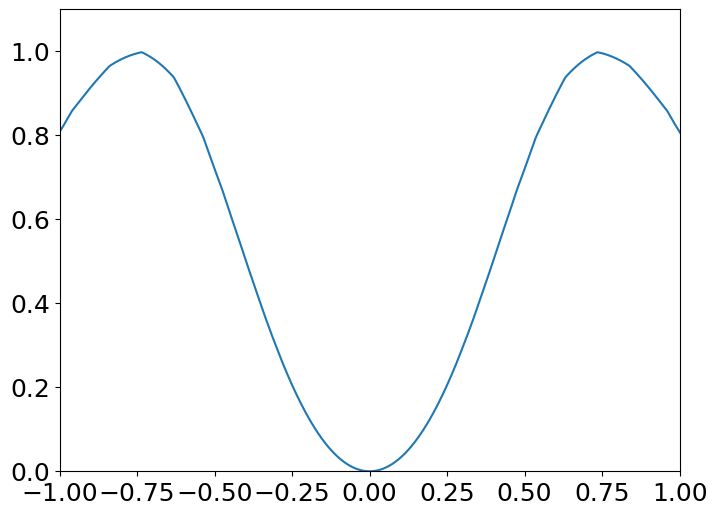

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(ys4[xs4==0]*1e3, Ups4[xs3==0])
plt.xlim((-1, 1))
plt.ylim((0, 1.1))

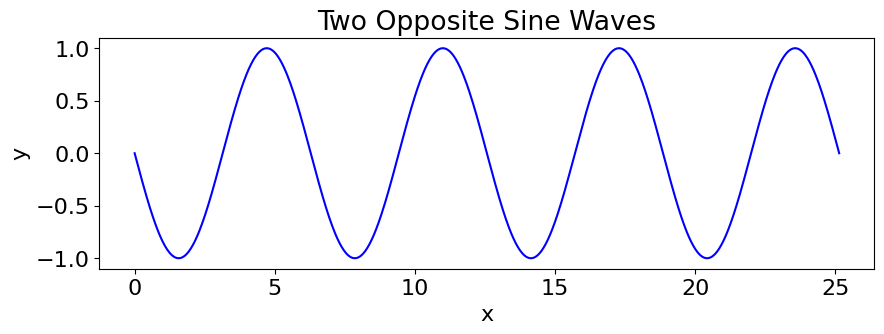

In [151]:
# Generate x values
x = np.linspace(0, 8 * np.pi, 1000)

# Calculate y values for sine and inverse sine
y_sine = np.sin(x)
y_inv_sine = -np.sin(x)

# Create the plot
plt.figure(figsize=(10, 3))
#plt.plot(x, y_sine, color='red', label='Sine Wave')
plt.plot(x, y_inv_sine, color='blue', label='Inverse Sine Wave')

# Adding labels
plt.title('Two Opposite Sine Waves')
plt.xlabel('x')
plt.ylabel('y')

# Remove grid
plt.grid(False)

# Add legend
#plt.legend()

# Show the plot
plt.show()
